# Garbage Classification using MobilenetV2

# Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from google.colab import drive
import pathlib

setup successful!


# Define Constants

In [2]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Path where our data is located
garbage_image_path = "/content/drive/MyDrive/Colab Notebooks/garbage/"

drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/Plogger

data_dir = pathlib.Path(garbage_image_path)

base_path = garbage_image_path


categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'glass', 6: 'non_garbage'}


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Plogger


# Create the model

The steps are:
1. Create an mobilenetv2 model without the last layer and load the ImageNet pretrained weights
2. Add a pre-processing layer
3. Add a pooling layer followed by a softmax layer at the end

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.mobilenet_v2 as mobilenetv2

mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                      #  weights = '../input/mobilenet-v2-keras-weights/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5')
 weights = "imagenet")

# We don't want to train the imported weights
mobilenetv2_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

model.add(mobilenetv2_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 7)                 8967      
                                                                 
Total params: 2266951 (8.65 MB)
Trainable params: 8967 (35.03 KB)
Non-trainable params: 2257984 (8.61 MB)
___________________

In [ ]:
mobilenetv2_layer.summary()

We will use the EarlyStopping call back to stop our training if the validation_accuray is not improving for a certain number of epochs.

In [4]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

# Split the Data Set

# Train the model

In [5]:
batch_size=64

datagen = image.ImageDataGenerator(

    ###  Augmentation Start  ###

    rotation_range=30,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip = True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2

    ##  Augmentation End  ###
)

In [6]:
train_generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    subset='training'
)


validation_generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    subset='validation'
)



Found 2434 images belonging to 7 classes.
Found 605 images belonging to 7 classes.


In [ ]:
EPOCHS = 7



with tf.device('/device:GPU:0'):
  history = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//batch_size,
      steps_per_epoch=train_generator.samples//batch_size,
      #callbacks=callbacks
  )

Epoch 1/7
 6/38 [===>..........................] - ETA: 17:14 - loss: 2.0814 - categorical_accuracy: 0.1719

In [ ]:
model.save_weights("model_include_non_garbage.h5")

# Visualize the training process


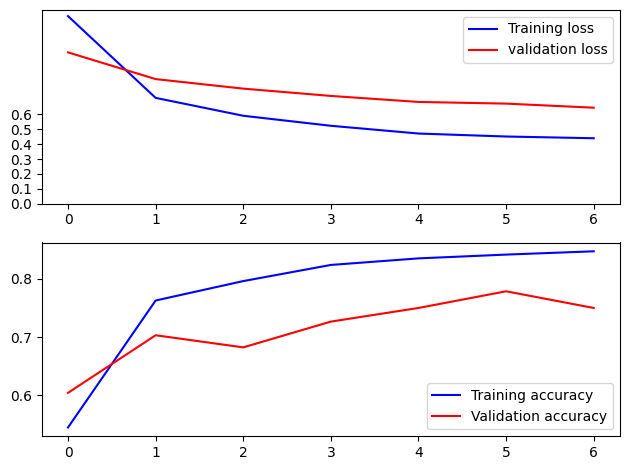

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 89ms/step
[[0.15314019 0.00849518 0.10371741 0.5747481  0.10599492 0.03128768
  0.02261655]]
Maximum Probability:  0.5747481
Classified: 3


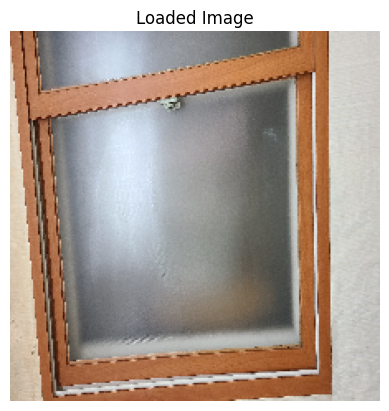

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

# test_dir = "/content/drive/MyDrive/Colab Notebooks/garbage/plastic/plastic75.jpg"
test_dir = "/content/drive/MyDrive/Colab Notebooks/garbage_test/window.jpg"



img_path = test_dir

img = image.load_img(img_path, target_size=IMAGE_SIZE)
img = image.img_to_array(img, dtype=np.uint8)
# img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])
print(p)

print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = np.argmax(p[0], axis=-1)


print("Classified:", predicted_class)



# Evaluate the test

In [ ]:
# We defined at the beginning of this notebook a dictionary that maps the categories number to names, but the train generator
# generated it's own dictionary and it has assigned different numbers to our categories and the predictions made by the model
# will be made using the genrator's dictionary.

gen_label_map = validation_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'non_garbage', 4: 'paper', 5: 'plastic', 6: 'trash'}


In [ ]:
import tensorflow as tf
import keras

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("MobilenetV2_include_non_garbage.tflite",'wb').write(tflite_model)

8903528